# Exploratory Notebook

ALL group members

## 1. Business Problem and Understanding

**Stakeholders:**

[business problem and background]

**Preliminary Questions include:**

-
-
- 

Databases:

**The goal:**

In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sqlite3
import re
from datetime import datetime

%matplotlib inline


In [2]:
# Load in csv & tsv data

# tsv's are tabbular and take '\t' as the delimiter
# 'rt.reviews.tsv' did not take default uft-8 decoding

df_gross = pd.read_csv('Data/bom.movie_gross.csv')
df_info = pd.read_csv('Data/rt.movie_info.tsv', delimiter='\t')
df_rev = pd.read_csv('Data/rt.reviews.tsv', delimiter='\t', encoding='latin-1')
df_db = pd.read_csv('Data/tmdb.movies.csv', index_col=0)
df_budg = pd.read_csv('Data/tn.movie_budgets.csv')

In [3]:
# create sql connection to database
conn = sqlite3.connect('Data/im.db')
cur = conn.cursor()

In [4]:
# Join movie_basics and movie_ratings & create df

q = ''' SELECT *
FROM movie_basics
JOIN movie_ratings
USING (movie_id)
'''

df_basics = pd.read_sql(q, conn)

In [5]:
# Join persons with directors
q = ''' SELECT *
FROM persons
JOIN directors
USING (person_id)
'''

df_directors = pd.read_sql(q, conn)

In [6]:
# Join persons with writers
q = ''' SELECT *
FROM persons
JOIN writers
USING (person_id)
'''

df_writers = pd.read_sql(q, conn)

In [7]:
# Join persons with known_for
q = ''' SELECT *
FROM persons
JOIN known_for
USING (person_id)
'''

df_known_for = pd.read_sql(q, conn)

In [8]:
# Create df for movie_akas

q = '''
SELECT *
FROM movie_akas
'''
df_akas = pd.read_sql(q,conn)

In [9]:
# Create df for principals

q = '''
SELECT *
FROM principals
'''
df_principals = pd.read_sql(q,conn)

## 2. Data Structure Exploration

In [10]:
# Create function to get df summary
def df_summary(df):
    print(df.head(3))
    print(df.info())
    print(df.isna().sum())
    print(df.isna().sum()/len(df)*100)

#### `df_basics`

- Drop nas
- Lowercase object columns

In [11]:
df_summary(df_basics)

    movie_id                    primary_title              original_title  \
0  tt0063540                        Sunghursh                   Sunghursh   
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind   

   start_year  runtime_minutes              genres  averagerating  numvotes  
0        2013            175.0  Action,Crime,Drama            7.0        77  
1        2019            114.0     Biography,Drama            7.2        43  
2        2018            122.0               Drama            6.9      4517  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int

#### `df_akas`

- Can use to compare language to gross amount

In [12]:
df_summary(df_akas)

    movie_id  ordering                                    title region  \
0  tt0369610        10                            Джурасик свят     BG   
1  tt0369610        11                        Jurashikku warudo     JP   
2  tt0369610        12  Jurassic World: O Mundo dos Dinossauros     BR   

  language        types attributes  is_original_title  
0       bg         None       None                0.0  
1     None  imdbDisplay       None                0.0  
2     None  imdbDisplay       None                0.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331703 entries, 0 to 331702
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   movie_id           331703 non-null  object 
 1   ordering           331703 non-null  int64  
 2   title              331703 non-null  object 
 3   region             278410 non-null  object 
 4   language           41715 non-null   object 
 5   types              16

#### `df_directors`, `df_writers`, `df_known_for`

- Without gender and other socio cultural details, not sure this information can be used.

In [13]:
df_summary(df_directors)
print('___________________________________________________________________________')
df_summary(df_writers)
print('___________________________________________________________________________')
df_summary(df_known_for)

   person_id    primary_name  birth_year  death_year  \
0  nm0062879  Ruel S. Bayani         NaN         NaN   
1  nm0062879  Ruel S. Bayani         NaN         NaN   
2  nm0062879  Ruel S. Bayani         NaN         NaN   

                          primary_profession   movie_id  
0  director,production_manager,miscellaneous  tt1592569  
1  director,production_manager,miscellaneous  tt1592569  
2  director,production_manager,miscellaneous  tt1592569  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291171 entries, 0 to 291170
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   person_id           291171 non-null  object 
 1   primary_name        291171 non-null  object 
 2   birth_year          68608 non-null   float64
 3   death_year          1738 non-null    float64
 4   primary_profession  290187 non-null  object 
 5   movie_id            291171 non-null  object 
dtypes: float64(2), object(4)
mem

#### `df_principals`

- Not sure if we will use this table
- If we do, we may be able to fill in from other tables

In [14]:
df_summary(df_principals)

    movie_id  ordering  person_id  category       job   characters
0  tt0111414         1  nm0246005     actor      None  ["The Man"]
1  tt0111414         2  nm0398271  director      None         None
2  tt0111414         3  nm3739909  producer  producer         None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1028186 entries, 0 to 1028185
Data columns (total 6 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   movie_id    1028186 non-null  object
 1   ordering    1028186 non-null  int64 
 2   person_id   1028186 non-null  object
 3   category    1028186 non-null  object
 4   job         177684 non-null   object
 5   characters  393360 non-null   object
dtypes: int64(1), object(5)
memory usage: 47.1+ MB
None
movie_id           0
ordering           0
person_id          0
category           0
job           850502
characters    634826
dtype: int64
movie_id       0.000000
ordering       0.000000
person_id      0.000000
category       0.

#### `df_gross`

- `df_budg` has more complete info on gross numbers. May not use.

In [15]:
df_summary(df_gross)

                                         title studio  domestic_gross  \
0                                  Toy Story 3     BV     415000000.0   
1                   Alice in Wonderland (2010)     BV     334200000.0   
2  Harry Potter and the Deathly Hallows Part 1     WB     296000000.0   

  foreign_gross  year  
0     652000000  2010  
1     691300000  2010  
2     664300000  2010  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB
None
title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype:

#### `df_info`

- Too many missing values. May not use.

In [16]:
df_summary(df_info)

   id                                           synopsis rating  \
0   1  This gritty, fast-paced, and innovative police...      R   
1   3  New York City, not-too-distant-future: Eric Pa...      R   
2   5  Illeana Douglas delivers a superb performance ...      R   

                                 genre          director  \
0  Action and Adventure|Classics|Drama  William Friedkin   
1    Drama|Science Fiction and Fantasy  David Cronenberg   
2    Drama|Musical and Performing Arts    Allison Anders   

                         writer  theater_date      dvd_date currency  \
0                Ernest Tidyman   Oct 9, 1971  Sep 25, 2001      NaN   
1  David Cronenberg|Don DeLillo  Aug 17, 2012   Jan 1, 2013        $   
2                Allison Anders  Sep 13, 1996  Apr 18, 2000      NaN   

  box_office      runtime             studio  
0        NaN  104 minutes                NaN  
1    600,000  108 minutes  Entertainment One  
2        NaN  116 minutes                NaN  
<class 'panda

#### `df_rev`

- Not sure if there is enough significant information.

In [17]:
df_summary(df_rev)

   id                                             review rating   fresh  \
0   3  A distinctly gallows take on contemporary fina...    3/5   fresh   
1   3  It's an allegory in search of a meaning that n...    NaN  rotten   
2   3  ... life lived in a bubble in financial dealin...    NaN   fresh   

           critic  top_critic         publisher               date  
0      PJ Nabarro           0   Patrick Nabarro  November 10, 2018  
1  Annalee Newitz           0           io9.com       May 23, 2018  
2    Sean Axmaker           0  Stream on Demand    January 4, 2018  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  in

#### `df_db`

- No nulls
- Create new column `release_year` from `release_date`

In [18]:
df_summary(df_db)

             genre_ids     id original_language  \
0      [12, 14, 10751]  12444                en   
1  [14, 12, 16, 10751]  10191                en   
2        [12, 28, 878]  10138                en   

                                 original_title  popularity release_date  \
0  Harry Potter and the Deathly Hallows: Part 1      33.533   2010-11-19   
1                      How to Train Your Dragon      28.734   2010-03-26   
2                                    Iron Man 2      28.515   2010-05-07   

                                          title  vote_average  vote_count  
0  Harry Potter and the Deathly Hallows: Part 1           7.7       10788  
1                      How to Train Your Dragon           7.7        7610  
2                                    Iron Man 2           6.8       12368  
<class 'pandas.core.frame.DataFrame'>
Index: 26517 entries, 0 to 26516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             -----------

#### `df_budg`

- No nulls
- 'movie' = 'title'
- Adjust 'release_date' if using for analysis
- Adjust 'gross' columns to int

In [19]:
df_summary(df_budg)

   id  release_date                                        movie  \
0   1  Dec 18, 2009                                       Avatar   
1   2  May 20, 2011  Pirates of the Caribbean: On Stranger Tides   
2   3   Jun 7, 2019                                 Dark Phoenix   

  production_budget domestic_gross worldwide_gross  
0      $425,000,000   $760,507,625  $2,776,345,279  
1      $410,600,000   $241,063,875  $1,045,663,875  
2      $350,000,000    $42,762,350    $149,762,350  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memor

## 3. Data Cleaning & Preprocessing

In [20]:
# Lowercase function
def lowercase(df):
    for col in df.columns:
        if df[col].dtype == object:
            df[col] = df[col].str.lower()
    return df

#### Cleaning df_basics

In [21]:
# Make cleaning copy
df_basics_c = df_basics.copy()
print("\nShape before cleaning:",df_basics_c.shape)

# Address lowercase
lowercase(df_basics_c)

# Replace 0s & blank spaces with nas
df_basics_c.replace(0,np.nan,inplace=True)
df_basics_c = df_basics_c.map(lambda x: np.nan if isinstance(x, str) and x.strip() == "" else x)
print("\nnan check:\n", df_basics_c.isna().sum()/len(df_basics_c)*100)

# Drop remaining nans
df_basics_c.dropna(inplace=True)

# Create primary_genre column
df_basics_c['primary_genre'] = df_basics_c.genres.apply(lambda x: x.split(',')[0])

# Get rid of duplicates based on movie_id
df_basics_c.drop_duplicates(inplace=True,subset='movie_id')

print("\nShape after cleaning:",df_basics_c.shape)
display(df_basics_c.head())


Shape before cleaning: (73856, 8)

nan check:
 movie_id            0.000000
primary_title       0.000000
original_title      0.000000
start_year          0.000000
runtime_minutes    10.317374
genres              1.088605
averagerating       0.000000
numvotes            0.000000
dtype: float64

Shape after cleaning: (65720, 9)


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,primary_genre
0,tt0063540,sunghursh,sunghursh,2013,175.0,"action,crime,drama",7.0,77,action
1,tt0066787,one day before the rainy season,ashad ka ek din,2019,114.0,"biography,drama",7.2,43,biography
2,tt0069049,the other side of the wind,the other side of the wind,2018,122.0,drama,6.9,4517,drama
4,tt0100275,the wandering soap opera,la telenovela errante,2017,80.0,"comedy,drama,fantasy",6.5,119,comedy
6,tt0137204,joe finds grace,joe finds grace,2017,83.0,"adventure,animation,comedy",8.1,263,adventure


It looks like this dataset is missing 10 years of information from the timeline we are looking at based on the release year in other databases which maxes out at 2020 and the information found about the newest era being post millenium.

**Source:** <a href = "http://www.historyoffilm.net/movie-eras/history-of-cinema/#:~:text=With%20over%20100%20years%20of,every%20decade%20of%20its%20history.">Movie Eras - History of Cinema and the First Film</a>

**note:** some of these databases, such as `df_basics_c` only go up to 2019. In the case of this present dataset, it also only begins at 2010, excluding 10 years from our intended analysis.

In [22]:
print("release_year range before filtering:", df_basics_c.start_year.min(), df_basics_c.start_year.max())

# Filter out years before 2000
df_basics_c = df_basics_c[df_basics_c['start_year']>1999]
print(df_basics_c.shape)

release_year range before filtering: 2010 2019
(65720, 9)


#### Cleaning df_db

While cleaning, certain 0s unmarked as nans were uncovered in the `average_votes` column. The number is small so we can drop these numbers. If we want to use in analysis for average votes for each `primary_genre` we can potentially distribute based on relative probability. Decided to check for object missingness not registering as nans and found ~9% of `genre_ids` missing as well.

To match `genre_ids` with their respective genre name, we used <a href = "https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee">The Movie Databse</a> as reference.

In [23]:
# Create a cleaning copy
df_db_c = df_db.copy()
print("\nShape before cleaning:",df_db_c.shape)

# Address lowercase
lowercase(df_db_c)
    
# create release_year column and convert to int
df_db_c['release_year'] = df_db_c['release_date'].apply(lambda x: int(x.split('-')[0]))

# strip genre_ids of []
df_db_c['genre_ids'] = df_db_c['genre_ids'].apply(lambda x: x.strip('[]').strip(""))

# Replace 0s & blank spaces with nas
df_db_c.replace(0,np.nan,inplace=True)
df_db_c = df_db_c.map(lambda x: np.nan if isinstance(x, str) and x.strip() == "" else x)
print('\nnan check:\n',df_db_c.isna().sum()/len(df_db_c)*100)

# Drop remaining nans
df_db_c.dropna(inplace=True)

# extract primary genre_id & create a new column 'primary_genre'
df_db_c['primary_genre'] = df_db_c['genre_ids'].apply(lambda x: x.split(',')[0])


data_text = '''
Action          28
Adventure       12
Animation       16
Comedy          35
Crime           80
Documentary     99
Drama           18
Family          10751
Fantasy         14
History         36
Horror          27
Music           10402
Mystery         9648
Romance         10749
Science_Fiction 878
TV Movie        10770
Thriller        53
War             10752
Western         37
'''

# Convert the text into a list of tuples
genre_list = [tuple(line.split(maxsplit=1)) for line in data_text.strip().split('\n')]

# Convert the list of into a dictionary
genre_dict = dict(genre_list)

# Iterate over each genre_ids to replace with genre name bsed on genre_dict
for k, v in genre_dict.items():
    df_db_c.loc[df_db_c['primary_genre'].str.contains(v), 'primary_genre'] = k.lower()

print("\nShape after cleaning:",df_db_c.shape)


Shape before cleaning: (26517, 9)

nan check:
 genre_ids            9.348720
id                   0.000000
original_language    0.000000
original_title       0.000000
popularity           0.000000
release_date         0.000000
title                0.000000
vote_average         0.512879
vote_count           0.000000
release_year         0.000000
dtype: float64

Shape after cleaning: (23922, 11)


In [24]:
print("release_year range before filtering:", df_db_c.release_year.min(), df_db_c.release_year.max())

# Filter out years before 2000
df_db_c = df_db_c[df_db_c['release_year']>1999]
print(df_db_c.shape)

release_year range before filtering: 1930 2019
(23806, 11)


It looks like `vote_average` is out of 10 so can be considered a 'rating' potentially. It's possible `popularity` is out of 100, though the max is 80.773. The max year is 2019, only a year away from our desired max which is closer to the range we want to use than other table with genre information.

In [25]:
# Explore columns

print("vote_average range:", df_db_c.vote_average.values.min(), df_db_c.vote_average.values.max())
print("popularity range:", df_db_c.popularity.values.min(), df_db_c.popularity.values.max())
print("release_year range:", df_db_c.release_year.min(), df_db_c.release_year.max())
print("top_10_languages:", df_db_c.original_language.value_counts().head(10))

vote_average range: 0.5 10.0
popularity range: 0.6 80.773
release_year range: 2000 2019
top_10_languages: original_language
en    20736
fr      495
es      424
ru      292
ja      253
de      227
zh      169
hi      168
it      110
ko       92
Name: count, dtype: int64


#### Cleaning df_budg

In [26]:
# Create cleaning copy
df_budg_c = df_budg.copy()
print("\nShape before cleaning:",df_budg_c.shape)

# Address lowercase 
lowercase(df_budg_c).head(10)

# Adjust release_date structure
df_budg_c.release_date = pd.to_datetime(df_budg_c.release_date,format='%b %d, %Y')
df_budg_c.release_date = df_budg_c.release_date.dt.strftime('%Y-%m-%d')

# Create release_year as an int
df_budg_c['release_year'] = df_budg_c['release_date'].apply(lambda x: int(x.split('-')[0]))

# Convert dollar columns to int
df_budg_c['production_budget'] = df_budg_c['production_budget'].str.replace(',', '').str.replace('$', '').astype(int)
df_budg_c['domestic_gross'] = df_budg_c['domestic_gross'].str.replace(',', '').str.replace('$', '').astype(int)
df_budg_c['worldwide_gross'] = df_budg_c['worldwide_gross'].str.replace(',', '').str.replace('$', '').astype(int)

# Create foreign_gross column
df_budg_c['foreign_gross'] = df_budg_c.worldwide_gross - df_budg_c.domestic_gross

# Replace 0s & blank spaces with nas
#df_budg_c.replace(0,np.nan,inplace=True)
df_budg_c = df_budg_c.map(lambda x: np.nan if isinstance(x, str) and x.strip() == "" else x)
print('\nnan check:\n',df_budg_c.isna().sum()/len(df_budg_c)*100)

# Drop remaining nans
df_budg_c.dropna(inplace=True)

print("\nShape after cleaning:",df_budg_c.shape)
df_budg_c.head()


Shape before cleaning: (5782, 6)

nan check:
 id                   0.0
release_date         0.0
movie                0.0
production_budget    0.0
domestic_gross       0.0
worldwide_gross      0.0
release_year         0.0
foreign_gross        0.0
dtype: float64

Shape after cleaning: (5782, 8)


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,foreign_gross
0,1,2009-12-18,avatar,425000000,760507625,2776345279,2009,2015837654
1,2,2011-05-20,pirates of the caribbean: on stranger tides,410600000,241063875,1045663875,2011,804600000
2,3,2019-06-07,dark phoenix,350000000,42762350,149762350,2019,107000000
3,4,2015-05-01,avengers: age of ultron,330600000,459005868,1403013963,2015,944008095
4,5,2017-12-15,star wars ep. viii: the last jedi,317000000,620181382,1316721747,2017,696540365


Adjust the year in the dataset based on estabilished range.

In [27]:
print("release_year range before filtering:", df_budg_c.release_year.min(), df_budg_c.release_year.max())

# Filter out years before 2000
df_budg_c = df_budg_c[df_budg_c['release_year']>1999]
print(df_budg_c.shape)

release_year range before filtering: 1915 2020
(4387, 8)


### Data Merging

We want to merge `df_budg_c` and `df_db` to compare grossing information with `popularity`, `vote_average`, and `primary_genre`. Since `df_budg_c` is so much smaller, it will serve as the base for this analysis to avoid having to drop nan rows. 

We will attempt to merge on `movie` and `title`, so first, we will adjust the names of those columns for ease then create a unique identifier column combining `movie_title` and `release_date`. Then we can clean up the data and delete any duplicate values.

**Note:** After deleting duplicates, there are still 4 records with the same `movie_id` identifier column in `df_db_c` we created. Since it is a small portion of the data, we drop those as well.

In [28]:
# Rename columns in each df
df_db_c.rename(columns={"title":"movie_title"},inplace=True)
df_budg_c.rename(columns={"movie":"movie_title"},inplace=True)

# Create unique identifier column in both dbs with movie_title + release_year to try to eliminate duplicate movie_titles
df_db_c['movie_id'] = df_db_c[['movie_title','release_date']].apply(lambda x: ''.join(x.astype(str)),axis=1)
df_budg_c['movie_id'] = df_budg_c[['movie_title','release_date']].apply(lambda x: ''.join(x.astype(str)),axis=1)

# Get rid of all characters in unique identifier column
df_db_c['movie_id'] = df_db_c['movie_id'].apply(lambda x: re.sub(r'[^\w\s]|_|\s', '', x))
df_budg_c['movie_id'] = df_budg_c['movie_id'].apply(lambda x: re.sub(r'[^\w\s]|_|\s', '', x))

# Get rid of duplicates
df_db_c.drop_duplicates(inplace=True,subset='movie_id')
df_budg_c.drop_duplicates(inplace=True,subset='movie_id')

df_db_c.movie_id.value_counts()
df_budg_c.movie_id.value_counts()

# Check shape of each dataset
print(df_budg_c.shape)
print(df_db_c.shape)

(4387, 9)
(22820, 12)


In [97]:
# Merge bsed on unique movie_id
db_budg = pd.merge(df_budg_c,df_db_c,on='movie_id')
db_budg.drop(['release_year_y','movie_title_y','release_date_y','id_y','id_x',
              'genre_ids','original_title'],inplace=True,axis=1)

Now we can repeat the process for `df_bd_c` and `df_basics_c` to be able to get more complete genre information.

In [30]:
# Rename columns in each df_basics
df_basics_c.rename(columns={"primary_title":"movie_title"},inplace=True)

# Create unique identifier column in both dbs with movie_title + release_year to try to eliminate duplicate movie_titles
df_db_c['movie_id2'] = df_db_c[['movie_title','release_year']].apply(lambda x: ''.join(x.astype(str)),axis=1)
df_basics_c['movie_id2'] = df_basics_c[['movie_title','start_year']].apply(lambda x: ''.join(x.astype(str)),axis=1)

# Get rid of all characters in unique identifier column
df_db_c['movie_id2'] = df_db_c['movie_id2'].apply(lambda x: re.sub(r'[^\w\s]|_|\s', '', x))
df_basics_c['movie_id2'] = df_basics_c['movie_id2'].apply(lambda x: re.sub(r'[^\w\s]|_|\s', '', x))


In [31]:
# Merge based on movie_id2
basics_db = pd.merge(df_basics_c,df_db_c, on='movie_id2')

# Drop unnecessary columns
to_drop = ['_x_x','_y','_x_y']
mask = basics_db.columns.str.contains('|'.join(to_drop))
basics_db.drop(basics_db.columns[mask],axis=1,inplace=True)

# Drop duplicates
basics_db.drop_duplicates(subset='movie_id_x',inplace=True)

basics_db

,movie_id_x,movie_title_x,original_title_x,runtime_minutes,genres,averagerating,numvotes,primary_genre_x,movie_id2,genre_ids,id,original_language,popularity,release_date,vote_average,vote_count
0,tt0069049,the other side of the wind,the other side of the wind,122.0,drama,6.9,4517,drama,theothersideofthewind2018,"35, 18",299782,en,9.800,2018-11-02,7.0,64
1,tt0192528,heaven & hell,reverse heaven,104.0,drama,4.0,72,drama,heavenhell2018,18,567662,en,0.600,2018-11-06,7.5,2
2,tt0255820,return to babylon,return to babylon,75.0,"biography,comedy,drama",5.9,123,biography,returntobabylon2013,"35, 18",323498,en,0.877,2013-08-11,7.0,1
3,tt0315642,wazir,wazir,103.0,"action,crime,drama",7.1,15378,action,wazir2016,"53, 28, 80, 18, 9648",275269,hi,3.881,2016-01-08,6.6,63
4,tt0326965,in my sleep,in my sleep,104.0,"drama,mystery,thriller",5.5,1889,drama,inmysleep2010,"53, 9648",40048,en,1.795,2010-04-23,5.4,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11634,tt9445054,bleed out,bleed out,88.0,documentary,8.6,207,documentary,bleedout2018,99,543661,en,0.600,2018-11-13,9.3,3
11635,tt9459550,american kamasutra,american kamasutra,88.0,"drama,romance",3.2,110,drama,americankamasutra2018,"18, 10749",571346,en,16.908,2018-12-13,4.1,9
11636,tt9495224,black mirror: bandersnatch,black mirror: bandersnatch,90.0,"drama,mystery,sci-fi",7.3,91349,drama,blackmirrorbandersnatch2018,"878, 9648, 18, 53, 10770",569547,en,12.282,2018-12-28,7.0,1932
11637,tt9546954,reel rock 13,reel rock 13,115.0,"documentary,sport",8.2,21,documentary,reelrock132018,99,575513,en,0.699,2018-11-01,9.5,1


Now we can repeat the process for `df_budg_c` and `df_basics_c` to compare which combination of information makes more sense to use for financial evalation of genres. Since the sample size for this combination is much smaller than that of `df_db_c` and `df_budg_c`, we will likely refer to `db_budg` for gross profit analyss.

In [45]:
# Create unique identifier column in df_budg_c with movie_title + release_year to try to eliminate duplicate movie_titles
df_budg_c['movie_id2'] = df_budg_c[['movie_title','release_year']].apply(lambda x: ''.join(x.astype(str)),axis=1)

# Merge based on movie_id2
basics_budg = pd.merge(df_basics_c,df_budg_c, on='movie_id2')

# Drop unnecessary columns
to_drop = ['_x_x','_y','_x_y','genres']
mask = basics_budg.columns.str.contains('|'.join(to_drop))
basics_budg.drop(basics_budg.columns[mask],axis=1,inplace=True)

# Drop duplicates
basics_budg.drop_duplicates(subset='movie_id_x',inplace=True)

basics_budg.groupby('primary_genre',observed=True)[['worldwide_gross']].mean().sort_values(by='worldwide_gross',ascending=False)
#db_budg.groupby('primary_genre',observed=True)[['worldwide_gross']].mean().sort_values(by='worldwide_gross',ascending=False)
basics_budg.shape

(368, 14)

In [139]:
# Save clean and merged data
df_basics_c.to_csv('Data/movie_basics_clean.csv',index=False)
df_db_c.to_csv('Data/tmbd_clean.csv',index=False)
df_budg_c.to_csv('Data/movie_budgets_clean.csv',index=False)
db_budg.to_csv('Data/tmdb_budgets.csv',index=False)
basics_db.to_csv('Data/basics_tmdb.csv',index=False)
basics_budg.to_csv('Data/movie_basics_budgets.csv',index=False)

## 4. Data Exploration and Analysis

#### Exploring Top Genres

In [33]:
df_basics_c.head()

,movie_id,movie_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,primary_genre,movie_id2
0,tt0063540,sunghursh,sunghursh,2013,175.0,"action,crime,drama",7.0,77,action,sunghursh2013
1,tt0066787,one day before the rainy season,ashad ka ek din,2019,114.0,"biography,drama",7.2,43,biography,onedaybeforetherainyseason2019
2,tt0069049,the other side of the wind,the other side of the wind,2018,122.0,drama,6.9,4517,drama,theothersideofthewind2018
4,tt0100275,the wandering soap opera,la telenovela errante,2017,80.0,"comedy,drama,fantasy",6.5,119,comedy,thewanderingsoapopera2017
6,tt0137204,joe finds grace,joe finds grace,2017,83.0,"adventure,animation,comedy",8.1,263,adventure,joefindsgrace2017


It looks like though, genres such as `game-show` and `music` have some of the highest ratings, they are not accompanied with a large number of votes (`numvotes`) within `df_basics_c`. 

In [34]:
# Evaluate genre within df_basics_c
df_basics_c['primary_genre'] = df_basics_c['primary_genre'].astype('category')
df_genre = df_basics_c.groupby('primary_genre', observed=False)[['averagerating','numvotes','runtime_minutes']].mean()
df_genre.sort_values(['averagerating','numvotes'],ascending=False)

,averagerating,numvotes,runtime_minutes
primary_genre,,,
game-show,9.000000,7.000000,130.000000
music,7.459864,284.210884,101.829932
documentary,7.295478,232.163240,86.936973
biography,7.183178,5355.570268,90.547698
sport,6.961765,67.676471,89.102941
reality-tv,6.750000,32.500000,155.000000
musical,6.716379,177.517241,107.594828
adventure,6.379862,11001.789666,90.730269
drama,6.351131,2432.743957,98.247568


#### Exploring top grossing movies

While exploring top grossing movies for each grossing category, we can see that there are 7 movies that present as top grossing movies overall. In general, `foreign_gross` is larger than `domestic_gross`. This is something we would want to consider within our proposal.

We can also see that the `popularity` of these movies may not be correlated with gross profits.

In [50]:
# Get top 10 grossing movies for each grossing category

# Top grossing numbers for domestic_gross
top_dom_gross = db_budg.domestic_gross.value_counts().index[0:10]
top_dg = db_budg.loc[db_budg['domestic_gross'].isin(top_dom_gross),['movie_title_x','popularity','primary_genre', 'domestic_gross',
                                                                    'foreign_gross', 'worldwide_gross', 
                                                                    'production_budget', 'movie_id']]

# Top grossing numbers for foreign_gross
top_for_gross = db_budg.foreign_gross.value_counts().index[0:10]
top_fg = db_budg.loc[db_budg['foreign_gross'].isin(top_for_gross),['movie_title_x','popularity','primary_genre', 'foreign_gross',
                                                                   'domestic_gross', 'worldwide_gross', 
                                                                   'production_budget', 'movie_id']]

# Top grossing numbers for worldwide_gross
top_ww_gross = db_budg.worldwide_gross.value_counts().index[0:10]
top_wg = db_budg.loc[db_budg['worldwide_gross'].isin(top_ww_gross),['movie_title_x','popularity','primary_genre', 'worldwide_gross',
                                                                    'domestic_gross', 'foreign_gross', 
                                                                    'production_budget', 'movie_id']]

# Combine to see which movies are top domestic & foreign gross
top_dgfg = pd.merge(top_dg,top_fg,on='movie_id')
to_drop = ['_x_x','_y','_x_y']
mask = top_dgfg.columns.str.contains('|'.join(to_drop))
top_dgfg.drop(top_dgfg.columns[mask],axis=1,inplace=True)


# Combine further to see which movies meet all 3 catefories
top_gross = pd.merge(top_dgfg,top_wg, on='movie_id')
to_drop = ['_x_x','_y','_x_y','_x']
mask = top_gross.columns.str.contains('|'.join(to_drop))
top_gross.drop(top_gross.columns[mask],axis=1,inplace=True)

display(top_dgfg.head())
display(top_gross.head())

,popularity_x,primary_genre_x,domestic_gross_x,foreign_gross_x,worldwide_gross_x,production_budget_x,movie_id
0,26.526,action,760507625,2015837654,2776345279,425000000,avatar20091218
1,10.187,comedy,0,0,0,60000000,theridiculous620151211
2,2.199,action,0,0,0,20000000,fightvalley20160722
3,12.324,thriller,0,0,0,18000000,theprince20140822
4,9.472,drama,0,0,0,18000000,forsaken20160219


,movie_id,popularity,primary_genre,worldwide_gross,domestic_gross,foreign_gross,production_budget
0,avatar20091218,26.526,action,2776345279,760507625,2015837654,425000000
1,theridiculous620151211,10.187,comedy,0,0,0,60000000
2,fightvalley20160722,2.199,action,0,0,0,20000000
3,theprince20140822,12.324,thriller,0,0,0,18000000
4,forsaken20160219,9.472,drama,0,0,0,18000000


#### Exploring top movies by `popularity` and `vote_average` in relation to gross data

Looking into most popular movies, we have further evidence that `popularity` and gross profits may not be closely related. Top grossing movies are not the same as most popular movies. In addition while `vote_average` and `popularity` seem to be related, they are not as related as we would expect as top movies by `vote_average` and top movies by `popularity` barely coinside.

As `popularity` is an arbitrary metrics when presented without context, we used the definition provided by <a href="https://developer.themoviedb.org/docs/popularity-and-trending">The Movie Database</a> as reference.

In [51]:
# Find top 10 movies by popularity
top_pop = db_budg.popularity.sort_values(ascending=False)[0:10]
top_pop_df = db_budg.loc[db_budg.popularity.isin(top_pop),['movie_title_x','popularity', 'vote_average','primary_genre', 
                                                           'domestic_gross','foreign_gross', 'worldwide_gross', 
                                                           'production_budget', 'movie_id']]

# Find top 10 movies by vote_average
top_votes = db_budg.vote_average.sort_values(ascending=False)[0:10]
top_votes_df = db_budg.loc[db_budg.vote_average.isin(top_votes),['movie_title_x','popularity', 'vote_average','primary_genre', 
                                                           'domestic_gross','foreign_gross', 'worldwide_gross', 
                                                           'production_budget', 'movie_id']]


display(top_pop_df.head())
display(top_votes_df.head())

,movie_title_x,popularity,vote_average,primary_genre,domestic_gross,foreign_gross,worldwide_gross,production_budget,movie_id
3,avengers: infinity war,80.773,8.3,adventure,678815482,1369318718,2048134200,300000000,avengersinfinitywar20180427
14,the hobbit: the battle of the five armies,53.783,7.3,action,255119788,690457833,945577621,250000000,thehobbitthebattleofthefivearmies20141217
17,the avengers,50.289,7.6,science_fiction,623279547,894656350,1517935897,225000000,theavengers20120504
36,fantastic beasts: the crimes of grindelwald,48.508,6.9,adventure,159555901,492664185,652220086,200000000,fantasticbeaststhecrimesofgrindelwald20181116
49,blade runner 2049,48.571,7.4,science_fiction,92054159,167303249,259357408,185000000,bladerunner204920171006


,movie_title_x,popularity,vote_average,primary_genre,domestic_gross,foreign_gross,worldwide_gross,production_budget,movie_id
3,avengers: infinity war,80.773,8.3,adventure,678815482,1369318718,2048134200,300000000,avengersinfinitywar20180427
63,coco,25.961,8.2,animation,209726015,588282086,798008101,175000000,coco20171122
81,interstellar,28.440,8.2,adventure,188017894,478361481,666379375,165000000,interstellar20141105
85,inception,27.920,8.3,action,292576195,542948447,835524642,160000000,inception20100716
668,green book,36.284,8.3,drama,85080171,236954268,322034439,23000000,greenbook20181116


## 5. Statistical Exploration & Analysis

To better understand what the correlation coefficient `r` means in terms of relationship strength we used the 'Rule of Thumb for Interpreting the Size of a Correlation Coefficient' provided in <a href='https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3576830/'>A guide to appropriate use of Correlation coefficient in medical research</a>.


<div style="width: 100%; text-align: center;">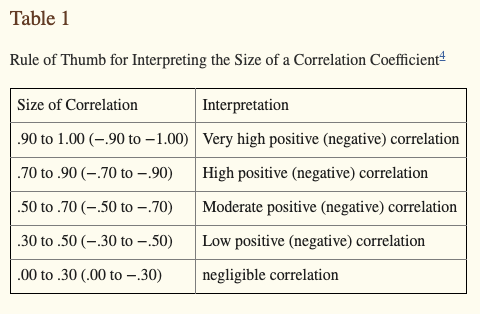</div>

#### `popularity` vs `averagerating`

Since we saw that `averagerating` per `primary_genre` in `df_basics_c` is not necessarily corresponding with a large number of votes, we should consider looking at how popularity correlates with ratings within the merged data base `basics_db`.

With an `r` at .17, the relationship between `popularity` and `averagerating` is negligible and shouldn't be considered.

Popularity vs Worldwide Gross
Correlation coefficient: 0.1666057988105624
p-value: 1.3169335576184567e-72


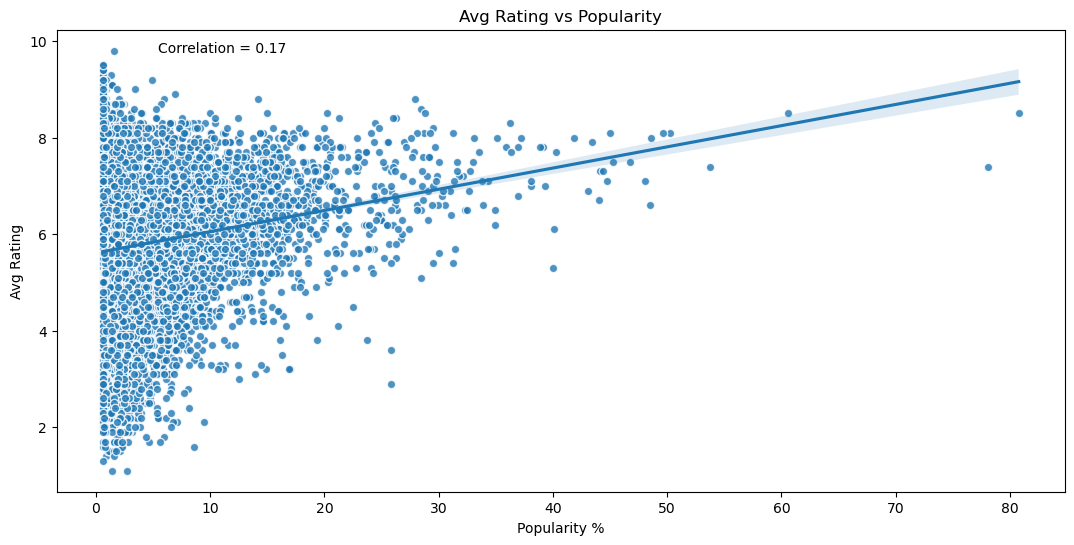

In [37]:
correlation, p_value = stats.pearsonr(basics_db.popularity,basics_db.averagerating)

print("Popularity vs Worldwide Gross")
print("Correlation coefficient:", correlation)
print("p-value:", p_value)

# Plot regplots
fig, axes = plt.subplots(figsize=(13,6),sharey=True)
sns.regplot(data=basics_db,x='popularity',y='averagerating',scatter_kws={'linewidths':1,'edgecolor':'w'})
plt.title('Avg Rating vs Popularity')
plt.xlabel('Popularity %')
plt.ylabel('Avg Rating')

# Plot correlation_label
correlation_label = f'Correlation = {np.round(correlation, 2)}'
plt.text(x=.1, y=.95, s=correlation_label, transform=plt.gca().transAxes);

#### `worldwide_gross` vs `popularity`, `vote_average`, and `production_budget`

When looking at `worldwide_gross` revenue and comparing it with `popularity`, `vote_average`, and `production_budget`, we can see that `p_value` is very small. Within each correlation, it is nearly zero and much less than the standard $\alpha$=.05. This means there is statistical significance in the correlations we see.

**`worldwide_gross` vs `popularity`**<br>
With a correlation coefficient (`r`) of ~.64, we can confirm that the more popular the movie, the higher the gross profit with a 'moderate' positive correlation. 

**`worldwide_gross` vs `vote_average`**<br>
With a `r` at ~.29, there is a negligible correlation, we can confirm that the `vote_average` is not a good signifier of `worldwide_gross` profits.

**`worldwide_gross` vs `production_budget`**<br>
There is a high positive correlation with `r` at ~.8, we can confirm that a higher `production_budget` is a good predicter of higher `worldwide_gross` profits.

We can visually conceptualize these relationship by the way the best-fit lines highlight the data distribution in the `sns.regplot`. While `popularity` and `production_budget` seem to have more of an impact on `worldwide_gross` with steeper slopes, `vote_average` clearly shows a less than signicant relationship with a nearly negligible slope.

Popularity vs Worldwide Gross
Correlation coefficient: 0.6422887186942021
p-value: 8.983702944346449e-152

Vote Average vs Worldwide Gross
Correlation coefficient: 0.2900890761347349
p-value: 1.4466788412482822e-26

Production Budget vs Worldwide Gross
Correlation coefficient: 0.7996040966241342
p-value: 4.393100229913725e-289


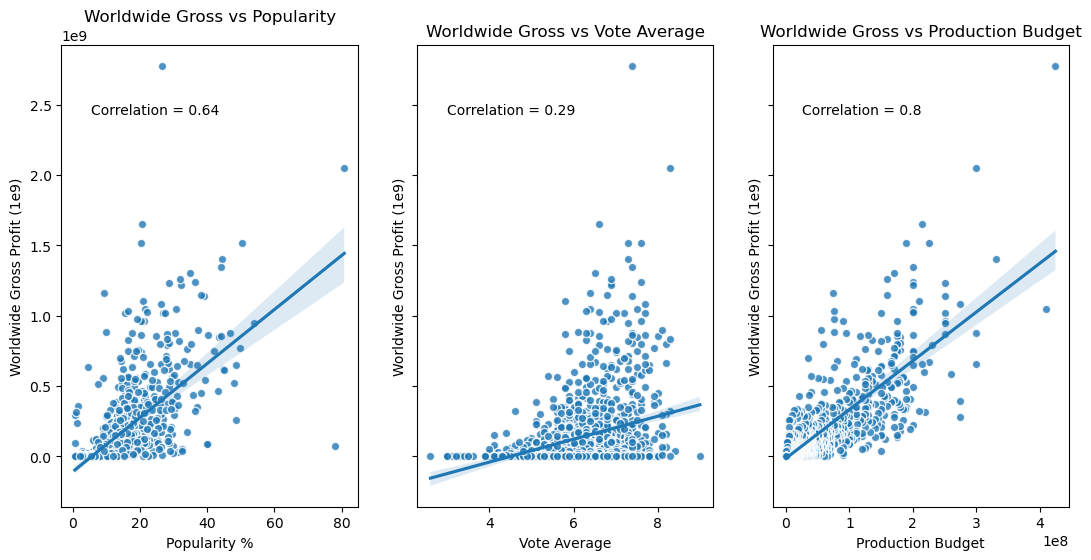

In [38]:
correlation, p_value = stats.pearsonr(db_budg.popularity,db_budg.worldwide_gross)
correlation1, p_value1 = stats.pearsonr(db_budg.vote_average,db_budg.worldwide_gross)
correlation2, p_value2 = stats.pearsonr(db_budg.production_budget,db_budg.worldwide_gross)

print("Popularity vs Worldwide Gross")
print("Correlation coefficient:", correlation)
print("p-value:", p_value)

print("\nVote Average vs Worldwide Gross")
print("Correlation coefficient:", correlation1)
print("p-value:", p_value1)

print("\nProduction Budget vs Worldwide Gross")
print("Correlation coefficient:", correlation2)
print("p-value:", p_value2)


# Plot regplots
fig, axes = plt.subplots(ncols=3,figsize=(13,6),sharey=True)
sns.regplot(data=db_budg,x='popularity',y='worldwide_gross',scatter_kws={'linewidths':1,'edgecolor':'w'},ax=axes[0])
axes[0].set_title('Worldwide Gross vs Popularity')
axes[0].set_xlabel('Popularity %')
axes[0].set_ylabel('Worldwide Gross Profit (1e9)')

sns.regplot(data=db_budg,x='vote_average',y='worldwide_gross', scatter_kws={'linewidths':1,'edgecolor':'w'},ax=axes[1])
axes[1].set_title('Worldwide Gross vs Vote Average')
axes[1].set_xlabel('Vote Average')
axes[1].set_ylabel('Worldwide Gross Profit (1e9)')

sns.regplot(data=db_budg,x='production_budget',y='worldwide_gross', scatter_kws={'linewidths':1,'edgecolor':'w'},ax=axes[2])
axes[2].set_title('Worldwide Gross vs Production Budget')
axes[2].set_xlabel('Production Budget')
axes[2].set_ylabel('Worldwide Gross Profit (1e9)')


# Plot correlation_label
correlation_label = f'Correlation = {np.round(correlation, 2)}'
axes[0].text(x=.1, y=.85, s=correlation_label, transform=axes[0].transAxes)
correlation_label1 = f'Correlation = {np.round(correlation1, 2)}'
axes[1].text(x=.1, y=.85, s=correlation_label1, transform=axes[1].transAxes)
correlation_label2 = f'Correlation = {np.round(correlation2, 2)}'
axes[2].text(x=.1, y=.85, s=correlation_label2, transform=axes[2].transAxes);

#### `production_budget` vs `popularity`

Since `production_budget` has a high positive correlation with `worldwide_gross`, we would want to see how it measures up against `popularity` and `vote_average`

Again, our results statistically significant (p<.05). With `r` being ~.63 we have a moderate positive correlation between `production_budget` and `popularity`. We can confirm that the `production_budget` is a moderately related to `popularity`.

Meanwhile, while we might have guessed otherwise, `vote_average` and `popularity` are not as closely related with a `r` at ~.36. This means there is a low positive correlation between the two. 


Production Budget vs Popularity
Correlation coefficient: 0.6254059236371357
p-value: 1.0654083597495806e-141

Vote Average vs Popularity
Correlation coefficient: 0.35860339087882986
p-value: 1.2047540028252273e-40


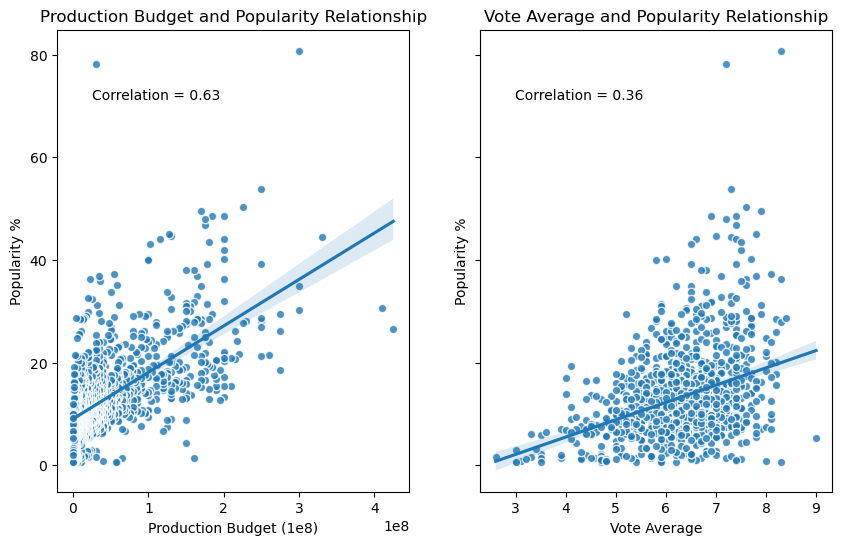

In [39]:
correlation, p_value = stats.pearsonr(db_budg.production_budget,db_budg.popularity)
correlation1, p_value1 = stats.pearsonr(db_budg.vote_average,db_budg.popularity)

print("\nProduction Budget vs Popularity")
print("Correlation coefficient:", correlation)
print("p-value:", p_value)

print("\nVote Average vs Popularity")
print("Correlation coefficient:", correlation1)
print("p-value:", p_value1)

# Plot scatterplot
fig, axes = plt.subplots(ncols=2, figsize=(10,6),sharey=True)
sns.regplot(data=db_budg,x='production_budget',y='popularity', 
            scatter_kws={'linewidths':1,'edgecolor':'w'}, ax=axes[0])
axes[0].set_title('Production Budget and Popularity Relationship')
axes[0].set_xlabel('Production Budget (1e8)')
axes[0].set_ylabel('Popularity %')

sns.regplot(data=db_budg,x='vote_average',y='popularity', 
            scatter_kws={'linewidths':1,'edgecolor':'w'},ax=axes[1])
axes[1].set_title('Vote Average and Popularity Relationship')
axes[1].set_xlabel('Vote Average')
axes[1].set_ylabel('Popularity %')

# Plot correlation_label
correlation_label = f'Correlation = {np.round(correlation, 2)}'
axes[0].text(x=.1, y=.85, s=correlation_label, transform=axes[0].transAxes)
correlation_label1 = f'Correlation = {np.round(correlation1, 2)}'
axes[1].text(x=.1, y=.85, s=correlation_label1, transform=axes[1].transAxes);

#### Primary Genre Analysis

Now that we understand the relationships between some of the main data we can start thinking about how to narrow down our recommendations based on data such as `production_budget`, `popularity`, and `primary_genre`.

We now want to see if it makes sense to narrow those down the genres by comparing `primary_genre` to `worldwide_gross` and `popularity`. It is interesting to visualize these details because while something may not be produced very much such as `science_fiction`, it can be quite profitable as well as popular.

Looking at `worldwide_gross` as compared with `production_budget` which had the highest positive correlation will be our priority. Then we would want to account for `popularity` as well since it had a moderate positive correlation to `worldwide_gross`.

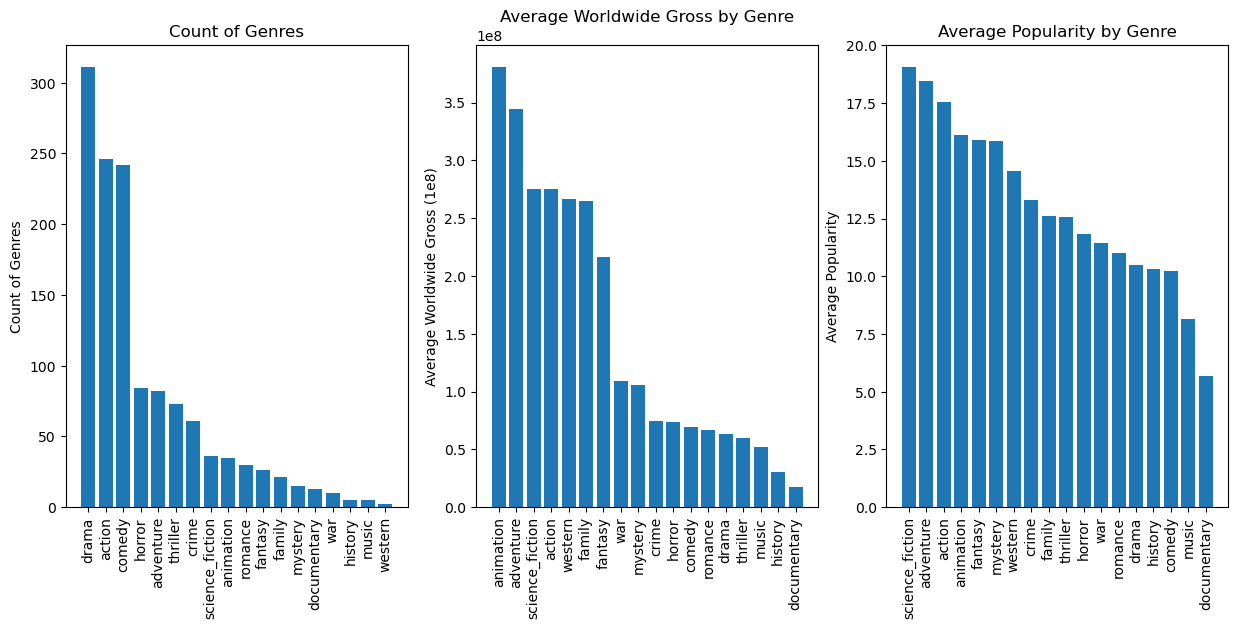

(1297, 15)

In [113]:
# Convert `primary_genre` to categorical
db_budg.primary_genre = pd.Categorical(db_budg.primary_genre)

# Get genre names & count
genres = db_budg.primary_genre.value_counts().index
genre_counts = db_budg.primary_genre.value_counts().values

# Get average `worldwide_gross` for each genre
gross_genre = db_budg.groupby('primary_genre',observed=True)[['worldwide_gross']].mean()
gross_genre_values = gross_genre.sort_values(by='worldwide_gross',ascending=False).values
gross_genre_names = gross_genre.sort_values(by='worldwide_gross',ascending=False).index

# Get average `popularity` for each genre
pop_genre = db_budg.groupby('primary_genre',observed=True)[['popularity']].mean()
pop_genre_values = pop_genre.sort_values(by='popularity',ascending=False).values
pop_genre_names = pop_genre.sort_values(by='popularity',ascending=False).index

# Plot the bar graphs
fig, ax = plt.subplots(ncols=3, figsize=(15,6))

ax[0].bar(genres,genre_counts)
ax[0].set_ylabel('Count of Genres')
ax[0].set_title('Count of Genres')
ax[0].set_xticks(range(len(genres)))
ax[0].set_xticklabels(genres,rotation=90)


ax[1].bar(gross_genre_names,gross_genre_values.flatten())
ax[1].set_ylabel('Average Worldwide Gross (1e8)')
ax[1].set_title('Average Worldwide Gross by Genre')
ax[1].set_xticks(range(len(gross_genre_names)))
ax[1].set_xticklabels(gross_genre_names,rotation=90)


ax[2].bar(pop_genre_names,pop_genre_values.flatten())
ax[2].set_ylabel('Average Popularity')
ax[2].set_title('Average Popularity by Genre')
ax[2].set_xticks(range(len(pop_genre_names)))
ax[2].set_xticklabels(pop_genre_names,rotation=90)



plt.show();

Visualizing these details all together below, we can conclude that from the perspective of highest grossing genres that are not only profitable but popular among viewers, the following are not a worthy investment for phase 1 of this business initiative.

- War
- Mystery
- Crime
- Horror
- Comedy
- Romance
- Drama
- Thriller
- Music
- History
- Documentary

**Note:** Though comedy and drama, make up many of the movies in our data subset, they are not as popular as one would expect nor nearly as profitable as other genres.

From this visual we are also able to understand which genres make a worthy investment. **Animation** and **Adventure**, though less frequent in our dataset with a high `production_budget`, is highest grossing and therefore a genre we will definitely be exploring. **Action** is another genre we will invest in as it is fairly profitable and popular with a moderate `production_budget`. 

**Science Fiction** is an interesting winner because it is the most popular genre though not as profitable as others like Animation.

Lastly, **Western** and **Family** are genres we would want to consider as well, as they are fairly profitable with a moderate `production_budget`.

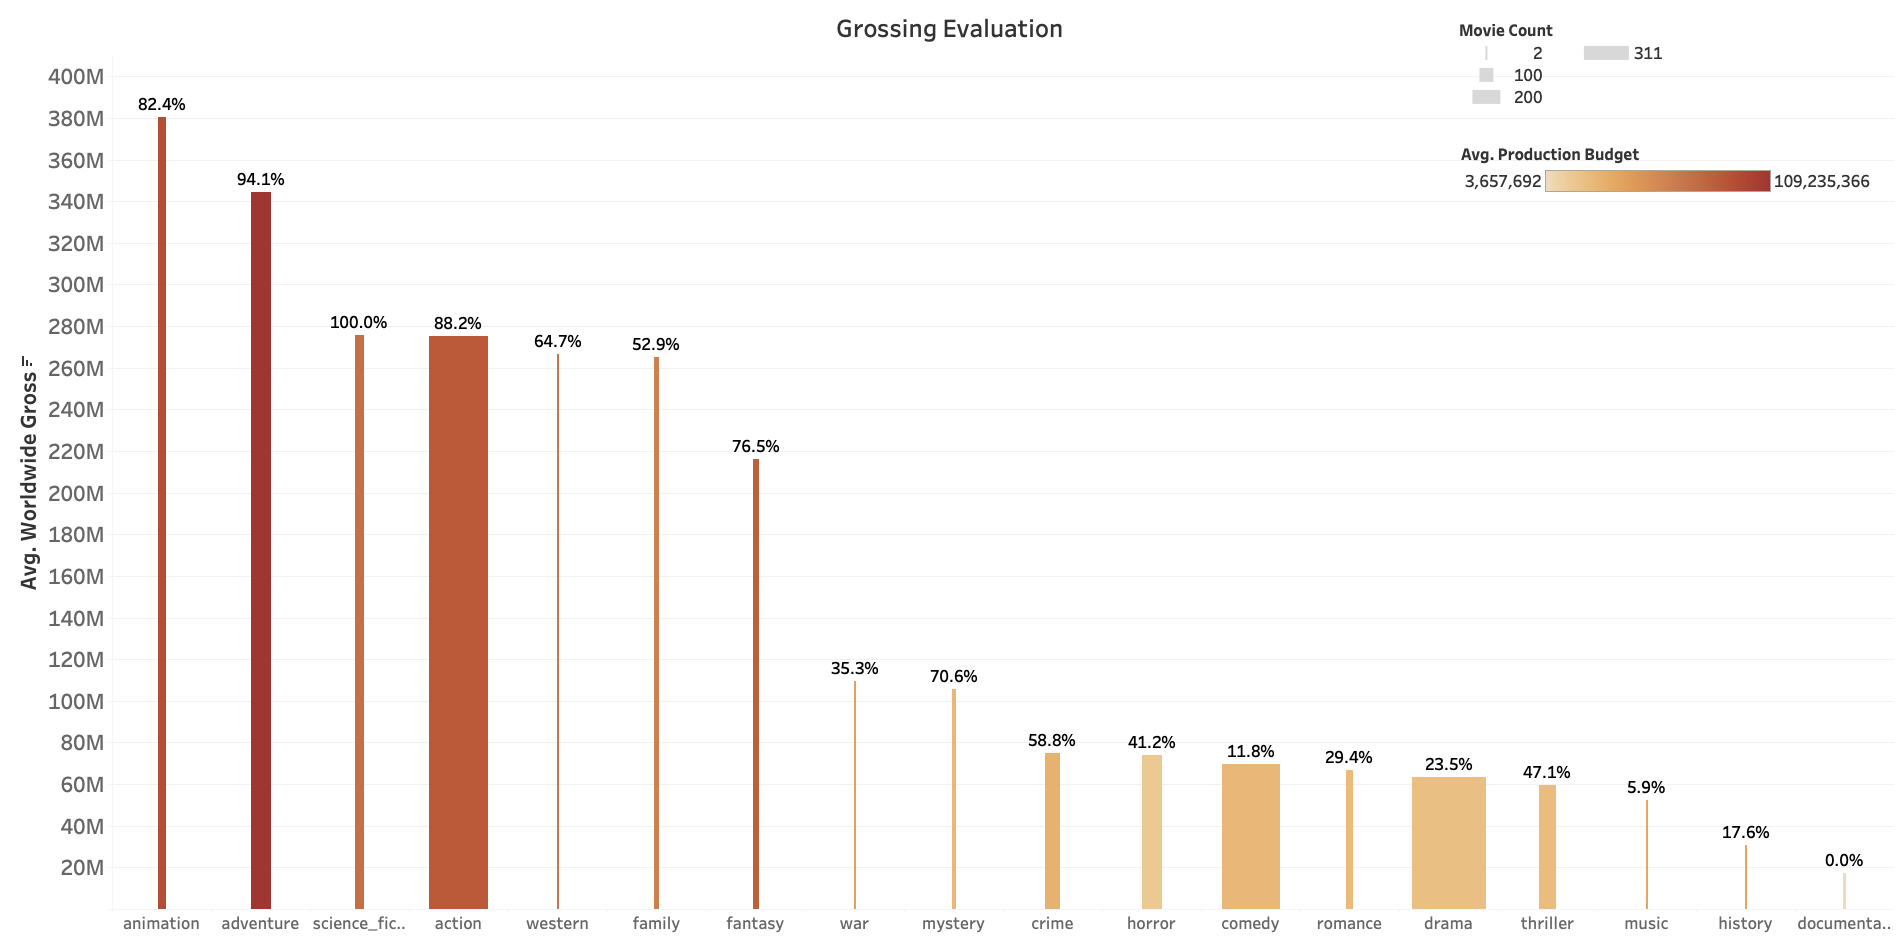

Lastly, we would want to determine relative budgets for each genre we are considering. We want to make sure that our grossing profits are at least as profitable as the appropriate measure of central tendency. Looking at the raw numbers in a table doesn't provide us enough of an understanding which measure of central tendency is representative for each genre of interest.

In [140]:
# Get the average production budget of the top grossing movies world wide while taking productivity into consideration
ww_gross_index = db_budg.worldwide_gross.value_counts().index
grouped_df = db_budg.loc[db_budg.worldwide_gross.isin(ww_gross_index),['primary_genre','worldwide_gross','production_budget','popularity']]

aggregations = {'worldwide_gross':'mean','production_budget':['mean','median','min'],'popularity':['mean']}
grouped_df = grouped_df.groupby('primary_genre',observed=True).agg(aggregations)
grouped_df.columns = ['Gross Mean','Budget Mean','Budget Median','Budget Min', 'Popularity Mean']
grouped_df.sort_values(by=['Gross Mean','Popularity Mean'],ascending=False)

,Gross Mean,Budget Mean,Budget Median,Budget Min,Popularity Mean
primary_genre,,,,,
animation,3.806330e+08,9.305714e+07,80000000.0,8000000,16.128457
adventure,3.441876e+08,1.092354e+08,99500000.0,1500000,18.468646
science_fiction,2.756185e+08,7.275403e+07,52600000.0,20000,19.055528
action,2.753119e+08,8.568577e+07,60000000.0,500000,17.547415
western,2.664990e+08,6.865000e+07,68650000.0,2300000,14.566500
family,2.651831e+08,6.145238e+07,36000000.0,2000000,12.594429
fantasy,2.161474e+08,8.158077e+07,58100000.0,2300000,15.890192
war,1.093101e+08,3.978000e+07,35000000.0,1300000,11.445200
mystery,1.058252e+08,2.564667e+07,19000000.0,200000,15.837067


Visualizing the `production_budget` in a boxplot, we can see where most data points lie within each genre and make some decisions about appropriate budget. We can conclude that the mean is not the best measure in this case since all of our data is fairly skewed. We may need some additional information to understand what budget is appropriate to ensure we maintain adequate `popularity` and `worldwide_gross`.

<div style = "text-align: center;"> 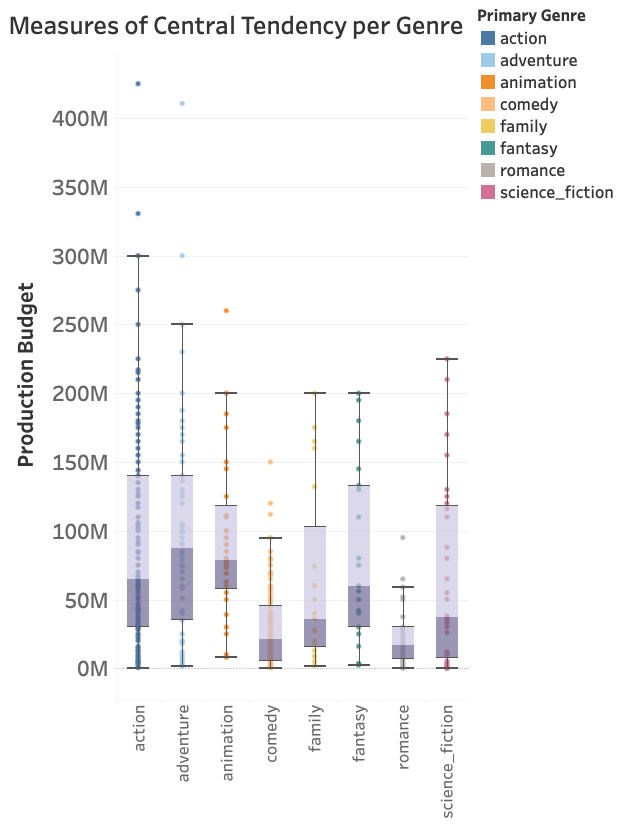</div>

## 6. Recommendations & Conclusion

**Data Limitation**

While there was a large amount of data available for analysis, much of the datasets and tables lacked appropriate information to add significance to analysis. 


**Recommendations**

<u>*Genres:*</u><br>


<u>*Production Budget by Genre:*</u><br>


<u>*Creators by Genre:*</u><br>


**Conclusion** <br>

<u>*Phase 1:*</u><br>

<u>*Looking Forward:*</u><br> As we continue to make our mark in the movie industry, we would want to take a deeper dive into both, what viewers prefer as well as what values we align with. Language is not something we delf deep into but we would like to look into how *language* plays a role in metrics we evaluated during our analysis for phase 1. In addition, certain data had information about creators who participated in the movies we had access to, but it lacked *demographic informatio* we would want to take into account. We are interested in investing in stories from minorities and other less represented populations.

